<a href="https://colab.research.google.com/github/4Leoj/Ball-Counting/blob/main/Ball_Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization
After initialization restart runtime and run again

In [1]:
!pip install matplotlib --upgrade
!pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from uncertainties import unumpy as unp
import uncertainties as un
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
from scipy.optimize import curve_fit
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
import pathlib as pl
import string
import warnings
from scipy.fft import rfft,rfftfreq
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import optimize
from numpy.linalg import norm
import scipy
warnings.filterwarnings("ignore")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams["figure.autolayout"] = True
matplotlib.rcParams['figure.figsize'] = [10, 5]
import inflect
p = inflect.engine()
sr = 22050

In [3]:
def Fit(f, xdata, ydata,p0=None, R = False, plot=True):
  xdata, ydata = np.array(xdata), np.array(ydata)
  if p0 is None:
    params, cov = curve_fit(f,xdata,ydata)
  else:
    params, cov = curve_fit(f,xdata,ydata, p0=p0)
  f_fit = lambda x: f(x,*params)
  err = np.sqrt(np.diag(cov))
  uParams = unp.uarray(params,err) 

  X = np.linspace(np.min(xdata),np.max(xdata),200)
  Y = f_fit(X)

  R2 = np.corrcoef(f_fit(xdata), ydata)[0,1]
  if plot:
    plt.plot(X,Y, label= f'$R^2$ = {R2:.2f}')
  if R:
    return uParams, f_fit, R2
  return uParams, f_fit

def Print_params(params):
  params = pd.DataFrame(params, columns = ['Fit params'])
  params.index = tuple(string.ascii_lowercase)[0:len(params)]
  form = lambda x: f'{x:.1uP}'
  params = params.applymap(form)

  # Style
  df1 = params.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
  return df1.set_properties(**{'text-align': 'center'})

def Energy(Data):
  E = []
  for y in Data.values():
    #y = np.log10(np.abs(y))
    #y = y[y>-8]
    E.append(np.dot(y,y))
  return E

def Energy_pred(fit_pa, Energies):
  Preds = []
  for energy in Energies:
    f = lambda x: fit_pa(x) - energy
    res = optimize.fsolve(f,[5,26])
    Preds.append(np.rint(res).astype(int))
  Preds = np.vstack(Preds) 
  return np.split(Preds,2,axis=1)

def li_pred(fit_pa, MFCC_4):
  Preds = []
  for energy in MFCC_4:
    f = lambda x: fit_pa(x) - energy
    res = optimize.fsolve(f,[4,25])
    Preds.append(np.rint(res).astype(int))
  Preds = np.vstack(Preds) 
  return np.split(Preds,2,axis=1)

In [4]:
''' for file in pl.Path('/content/drive/MyDrive/Ball_counting/Train_balls/2').glob('*'):
  file.rename(pl.Path(file.parent,file.stem.replace('a','')+file.suffix)) '''

" for file in pl.Path('/content/drive/MyDrive/Ball_counting/Train_balls/2').glob('*'):\n  file.rename(pl.Path(file.parent,file.stem.replace('a','')+file.suffix)) "

# Load training data

In [5]:
def Load(path):
  Data = {}
  for file in pl.Path(path).glob('*'):
    y, sr = librosa.load(str(file))
    Data[int(file.stem)] = y
  Data = dict(sorted(Data.items()))
  return Data

In [8]:
DATA, path = [], '/content/drive/MyDrive/Ball_counting/Train_balls/'
for i in range(1,4):
  DATA.append(Load(f'{path}{i}'))
DATA = pd.DataFrame(DATA)
N = list(DATA.columns)

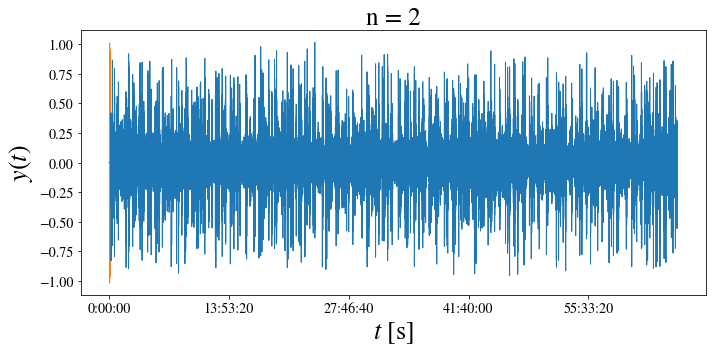

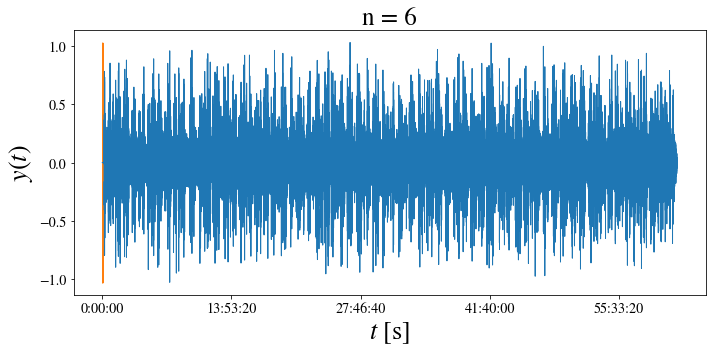

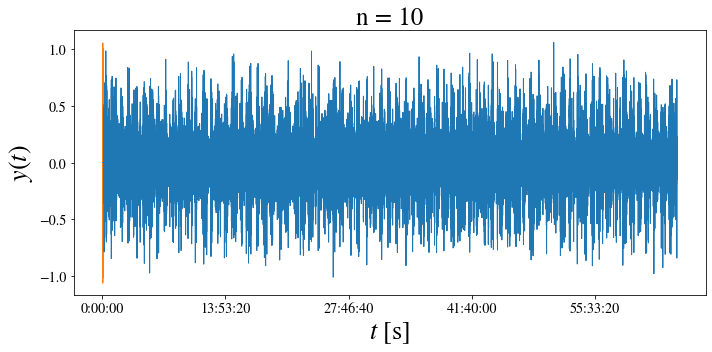

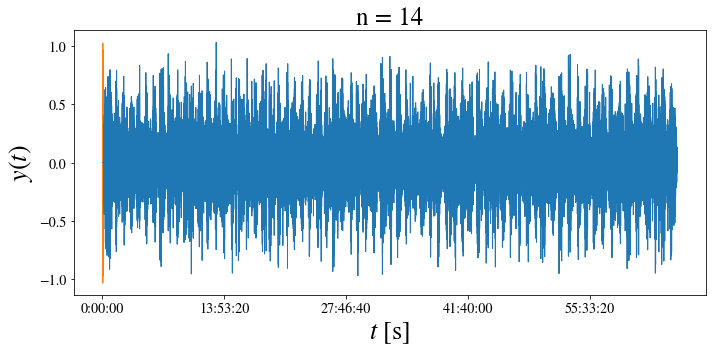

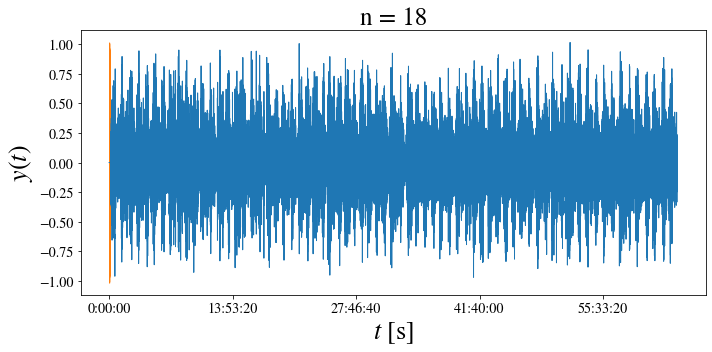

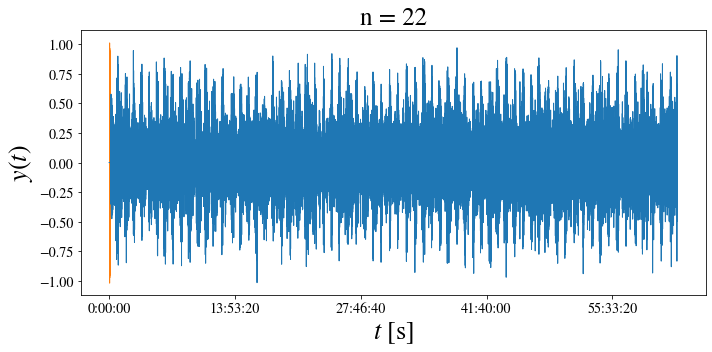

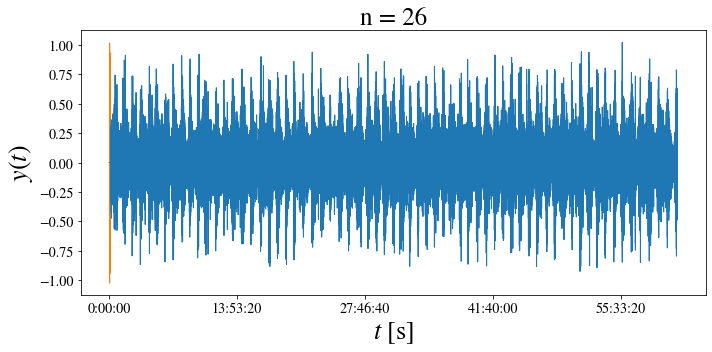

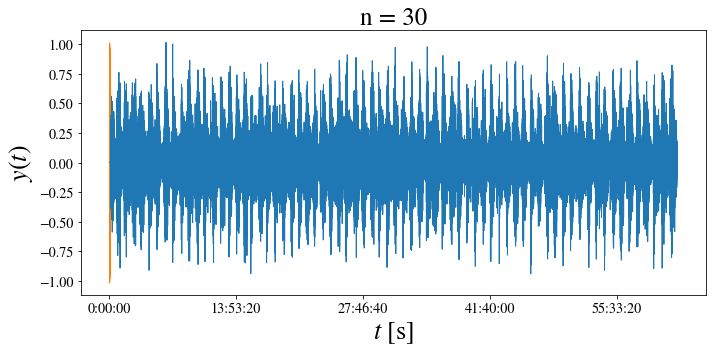

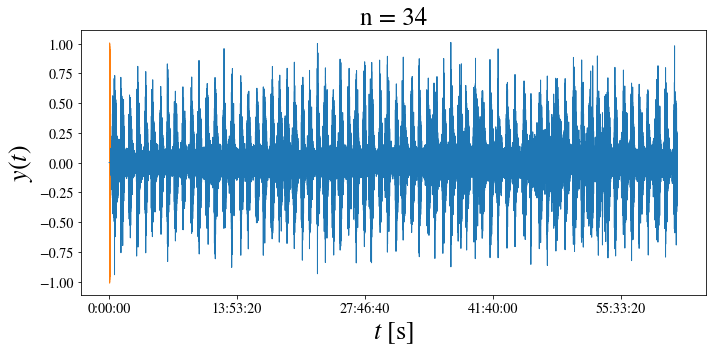

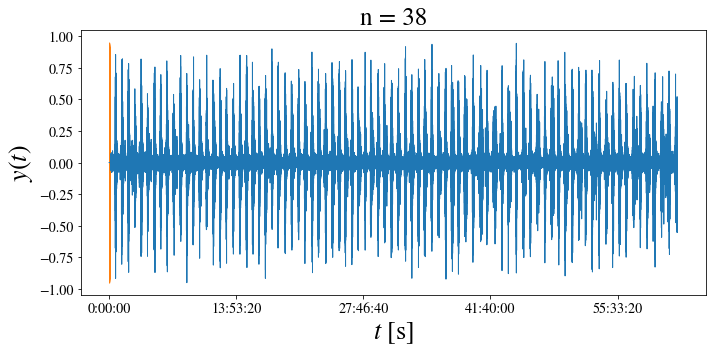

In [9]:
for n, y in DATA.loc[0].items():
  ipd.display(ipd.Audio(data = y, rate=sr))
  plt.plot(y,lw=1)
  librosa.display.waveshow(y, sr=sr,)
  plt.xlabel('$t$ [s]',size=26)
  plt.ylabel('$y(t)$', size=26)
  plt.title(f'{n = }', size = 25)
  plt.show()

# Signal energy
$\qquad \Huge E_s = \sum y(t)^2$

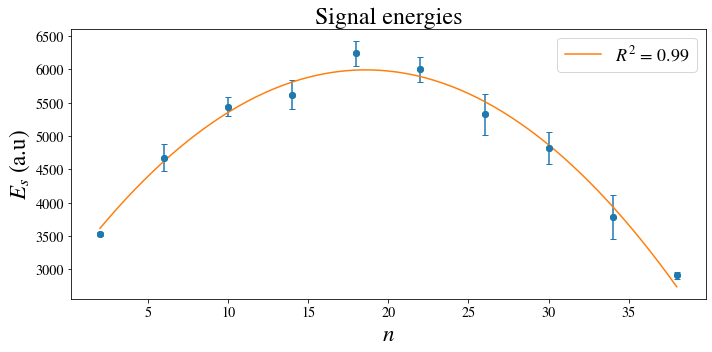

In [10]:
ENERGY = DATA.applymap(norm)**2
E = ENERGY.mean().values
plt.errorbar(N, E, yerr = ENERGY.std().values,fmt = 'o',capsize=3)

pa = lambda x, a, b, c: a*x**2 + b*x + c 
pa_params, fit_pa = Fit(pa, N, E) 
plt.legend(fontsize=18)
#plt.hlines(E[0],-4,301,'gold',linestyles='dashed', lw=2.5)
plt.title('Signal energies', size = 24)
plt.xlabel('$n$', size = 23)
plt.ylabel('$E_s$ (a.u)', size = 23)
plt.plot(N,E, 'o');

In [11]:
Print_params(pa_params)

In [ ]:
# Maxima
print(np.argmax(fit_pa(np.linspace(1,300,300))))

18


# Flatness

In [12]:
def flatness(y):
  return np.mean(librosa.feature.spectral_flatness(y))

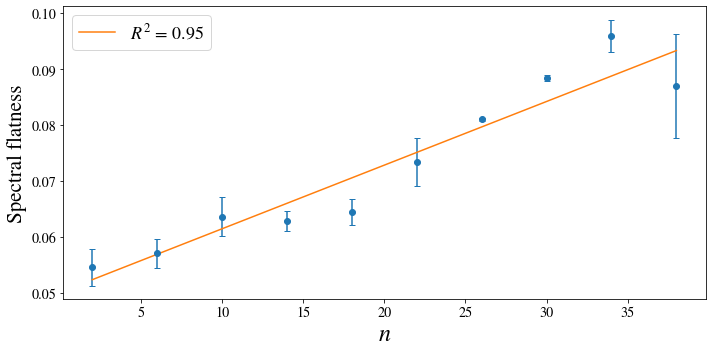

In [13]:
Flatness = DATA.applymap(flatness)
F = Flatness.mean().values

plt.errorbar(N, F, yerr = Flatness.std().values,fmt = 'o',capsize=3)

pa_fla = lambda x, a,b: a*x+b
pa_fla_params, fit_pa_fla = Fit(pa_fla,N,F)
plt.legend(fontsize=18)
#plt.hlines(E[0],-4,301,'gold',linestyles='dashed', lw=2.5)
plt.ylabel('Spectral flatness', size=21)
plt.xlabel('$n$', size=24);

In [14]:
Print_params(pa_fla_params)

# MFCC

<img src="https://drive.google.com/uc?id=10brUC0lCrHrOoEgss2AxbGjiZFmkLkD_" width="50%"/>

## Analysis

In [15]:
def Mfcc(y):
  N_MFCC = 8
  Mfccs = librosa.feature.mfcc(y, n_mfcc = N_MFCC, sr=sr) # mfcc
  return np.mean(Mfccs, axis = 1)

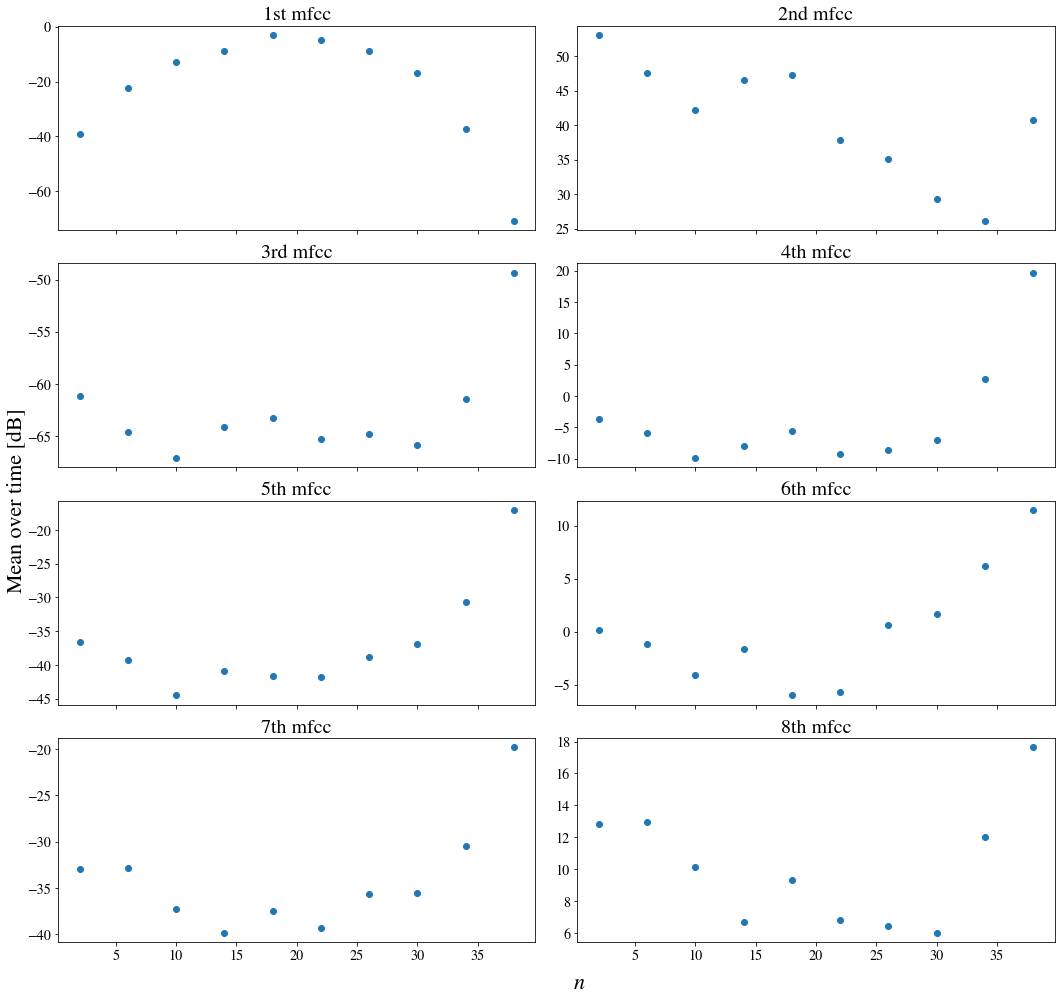

In [16]:
Mfccs = DATA.applymap(Mfcc)
Mfccs_mean = np.apply_along_axis(lambda x:np.mean(np.vstack(x),axis=0), 0, Mfccs.values)
Mfccs_std = np.apply_along_axis(lambda x:np.std(np.vstack(x),axis=0), 0, Mfccs.values)

fig, axs = plt.subplots(4,2, figsize = (15,14),sharex = True)
for (n_mfcc, mfcc_m), ax in zip(enumerate(Mfccs_mean,1), axs.flat):
  ax.set_title(f'{p.ordinal(n_mfcc)} mfcc', size = 20)
  ax.plot(N,mfcc_m, 'o')
  #plt.plot(N,mfcc_m, 'o')
  #plt.show()

fig.supxlabel('$n$', size = 22, x = .55)
fig.supylabel('Mean over time [dB]', size = 22)
plt.show(); 

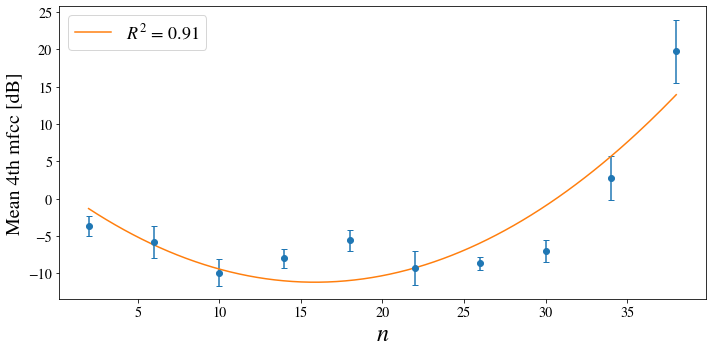

In [17]:
plt.errorbar(N,Mfccs_mean[3], yerr=Mfccs_std[3], fmt='o',capsize=3)

#li = lambda x, a, b: a*x+b
li = lambda x, a, b,c: a*x**2+b*x+c
li_params, fit_li = Fit(li,N,Mfccs_mean[3])

#plt.title('Linear fit', size = 22)
plt.ylabel('Mean 4th mfcc [dB]',size=20)
plt.xlabel('$n$',size=24)
plt.legend(fontsize=18);

In [ ]:
Print_params(li_params)

# Melspectrogram

Text(0.5, 0, '$t$ [s]')

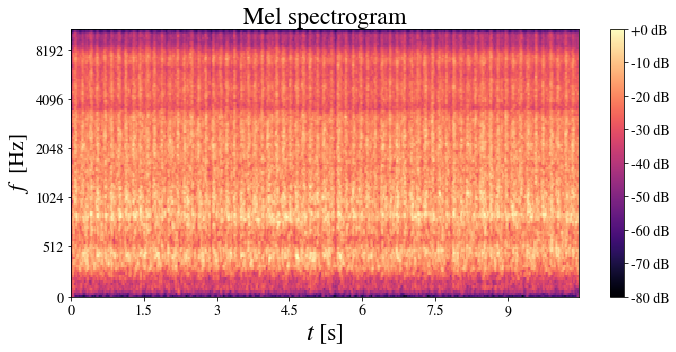

In [19]:
n = 18
S= librosa.feature.melspectrogram(y= DATA.at[0,n], sr=sr)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set_title(f'Mel spectrogram', size=24)
plt.ylabel('$f$  [Hz]', size=22)
plt.xlabel('$t$ [s]', size=24)

## mfcc

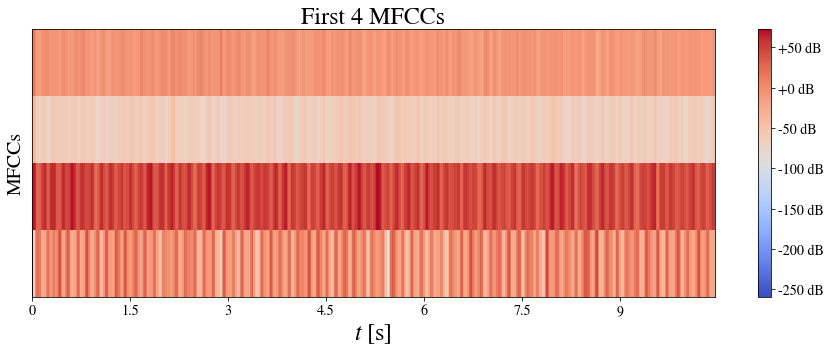

In [20]:
plt.figure(figsize=(12.5, 5))
mfccs = librosa.feature.mfcc(y=DATA.at[0,n], n_mfcc=4, sr=sr,)
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f dB")
plt.title(f'First 4 MFCCs', size=24)
plt.ylabel('MFCCs', size=20)
plt.xlabel('$t$ [s]', size=24)
plt.show()

# FFT


- $\large f_{lmn}=\frac{c}{2}\sqrt{\left(\frac{l}{L_x}\right)^2+\left(\frac{m}{L_y}\right)^2+\left(\frac{n}{L_z}\right)^2}$

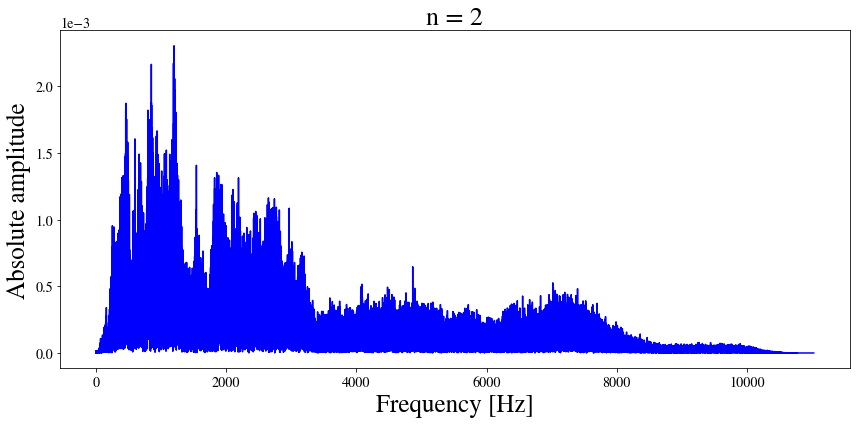

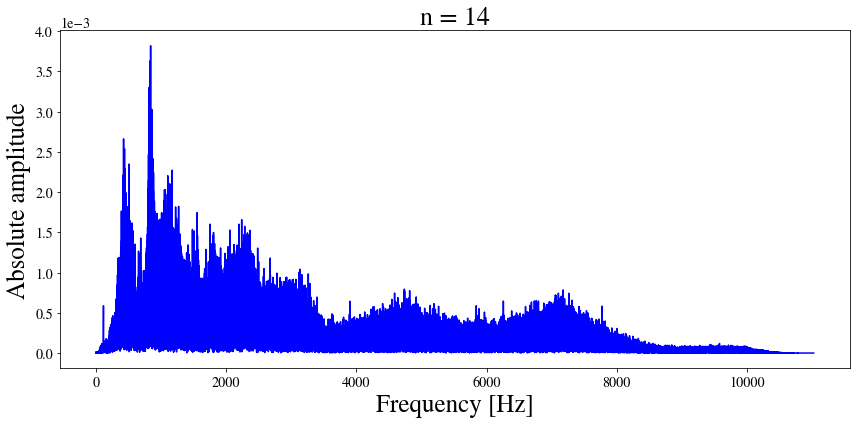

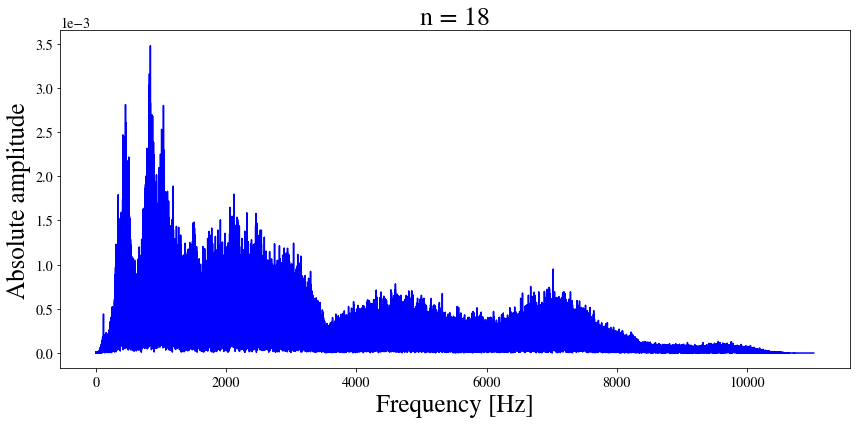

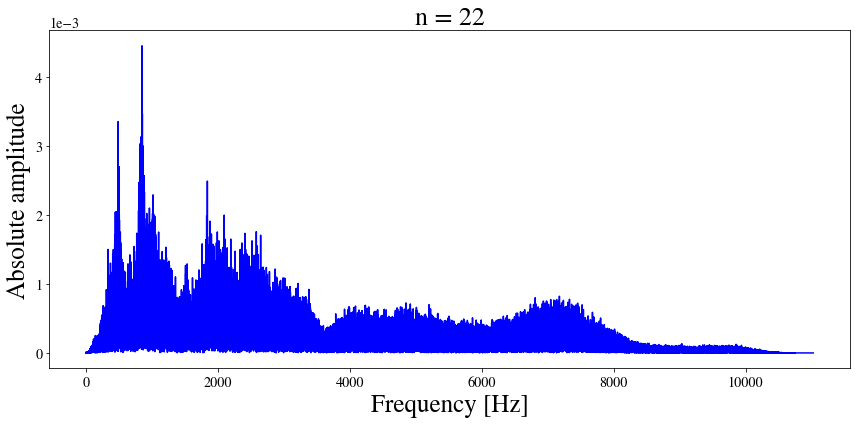

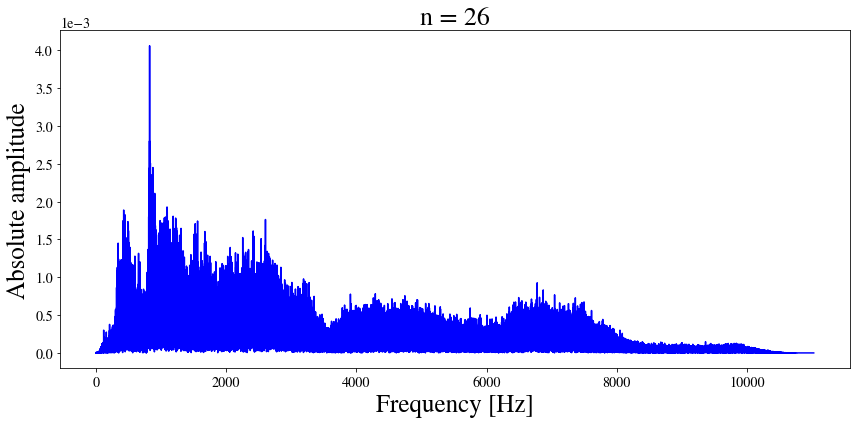

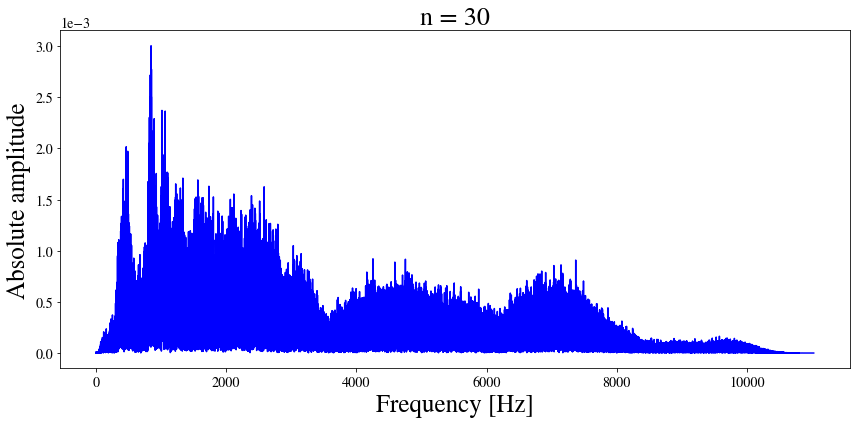

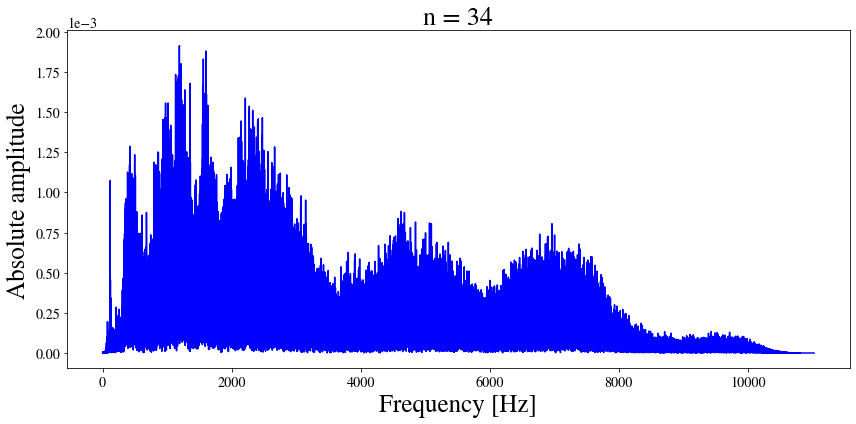

In [21]:
def Plot_fft(x):
  X = rfft(x)
  X = np.abs(X)
  #X = savgol_filter(X, 501, 3)
  freq = rfftfreq(x.size,1/sr)
  plt.figure(figsize = (12, 6))
  #freq,X = freq[2:1000], X[2:1000]
  plt.plot(freq, X/x.size, c= 'b')
  plt.xlabel('Frequency [Hz]', size = 25)
  plt.ylabel('Absolute amplitude', size = 25)
  plt.ticklabel_format(axis='y', style='sci',scilimits=(1,4))

for n,y in DATA.loc[0].items():
  Plot_fft(y)
  plt.title(f'{n = }', size  = 26)

## Energy ratio
$\Large E_r(S)=\frac{E_{high}}{E_{low}}=\frac{\sum_{k=S+1}^{N-1} | Y[k] |^2}{\sum_{k=0}^{S} | Y[k] |^2} $

In [22]:
def Ratio(fr_split, F,X):
  mask = F < fr_split
  X_low, X_high = X[mask], X[~mask]
  return sum(X_high)/sum(X_low)

In [23]:
def Plot_ratio(fr_split):

  RATIOS = []
  for row in DATA.values:
    Ratios = []
    for y in row:
      Y = rfft(y)
      Y = np.abs(Y)**2
      freq = rfftfreq(y.size,1/sr)
      Ratios.append(Ratio(fr_split,freq,Y))
    RATIOS.append(Ratios)
  RATIOS = np.array(RATIOS)
  Na = np.array(N)

  plt.errorbar(Na,np.mean(RATIOS,axis=0),yerr=np.std(RATIOS,axis=0),fmt='o',capsize=3)
  # Fit
  lin = lambda x, a, b: a*x+b
  lin_params, fit_lin = Fit(lin,Na,np.mean(RATIOS,axis=0))
  plt.legend(fontsize=15)
  return fit_lin

In [24]:
def R_ratio(fr_split):

  RATIOS = []
  for row in DATA.values:
    Ratios = []
    for y in row:
      Y = rfft(y)
      Y = np.abs(Y)**2
      freq = rfftfreq(y.size,1/sr)
      Ratios.append(Ratio(fr_split,freq,Y))
    RATIOS.append(Ratios)
  RATIOS = np.array(RATIOS)
  Na = np.array(N)

  lin = lambda x, a, b: a*x+b
  lin_params, fit_lin,R = Fit(lin,np.mean(RATIOS,axis=0),Na, R=True, plot=False)
  
  return R

In [25]:
RR = []
Range = np.arange(100,5120,20)
for freq_split in Range: 
  R = R_ratio(freq_split)
  RR.append(R)

Text(3190, 0.45, '$f_S^*$ = 3140 [Hz]')

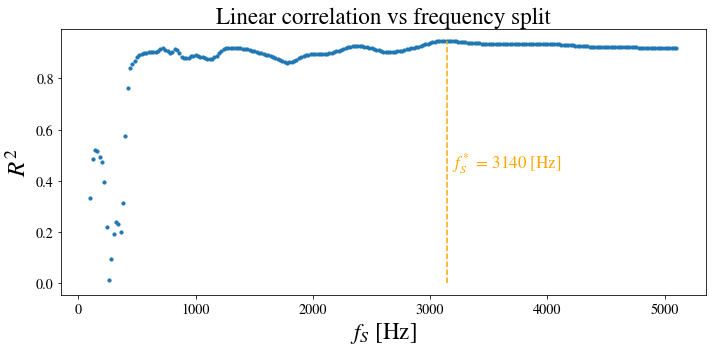

In [26]:
plt.scatter(Range,RR, s=10)
plt.xlabel('$f_S$ [Hz]',size=23)
plt.ylabel('$R^2$',size=25)
plt.title('Linear correlation vs frequency split', size=23)
plt.vlines(x=3140,ymin=0,ymax=0.945, color='orange',linestyles='dashed')
plt.text(x=3190,y=0.45,s='$f_S^*$ = 3140 [Hz]', color ='orange', size=17)

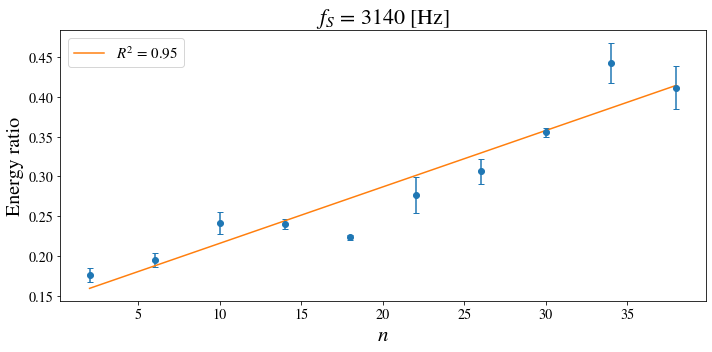

In [27]:
f = 3140
Plot_ratio(f)
plt.xlabel('$n$',size=21)
plt.ylabel('Energy ratio',size=20)
plt.title(f'$f_S$ = {f} [Hz]', size=22);

In [28]:
Range[find_peaks(RR)[0]]

array([ 140,  320,  620,  720,  820, 1000, 1280, 1360, 2020, 2380, 3140,
       3560, 3900, 4440, 4520, 4600, 5000])

In [29]:
np.argsort(np.array(RR)[find_peaks(RR)[0]])

array([ 1,  0,  5,  8,  2,  4,  7,  3,  6, 16, 13, 14, 15,  9, 12, 11, 10])

In [30]:
np.array(RR)[find_peaks(RR)[0]]

array([0.51833931, 0.23731738, 0.90358802, 0.91822778, 0.91324182,
       0.89023275, 0.91985786, 0.91679281, 0.8959835 , 0.92743039,
       0.94605874, 0.93527423, 0.93483058, 0.92342573, 0.92345528,
       0.92361151, 0.92002048])

# Test

In [31]:
Data_test = {}
for file in pl.Path('/content/drive/MyDrive/Ball_counting/Test_balls/').glob('*'):
  y, sr = librosa.load(str(file))
  Data_test[int(file.stem)] = y
Data_test = dict(sorted(Data_test.items()))

## MFCC test

In [32]:
N_MFCC = 4
MFCC_M_test = {i:[] for i in range(1,N_MFCC+1)}
for y in Data_test.values():
  Mfccs = librosa.feature.mfcc(y, n_mfcc = N_MFCC, sr=sr)
  for i, me in enumerate(np.mean(Mfccs, axis = 1), 1):
    MFCC_M_test[i].append(me)
#####
Pred_li = pd.DataFrame({'n':list(Data_test.keys()),'4th mean mfcc':MFCC_M_test[4]})
Pred_li['1st Prediction'], Pred_li['2nd Prediction'] = li_pred(fit_li, MFCC_M_test[4])
err1, err2 = np.abs((1-Pred_li['1st Prediction']/Pred_li['n'])), np.abs((1-Pred_li['2nd Prediction']/Pred_li['n']))
Pred_li['Error'] = np.rint(np.min(np.vstack([err1,err2]),axis=0)*100).astype(int)

Pred_model_li = np.argmin(np.vstack([err1,err2]),axis=0)

Mean_error_li = str(int(np.rint(np.mean(Pred_li['Error']))))+'%'
# style
Pred_li['Error'] = Pred_li['Error'].astype(str) + '%'
st = Pred_li.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
st.set_properties(**{'text-align': 'center'}).hide_index()

In [33]:
print(Mean_error_li)

25%


## Energy test

In [34]:
Pred_en = pd.DataFrame({'n':list(Data_test.keys())})
Pred_en['1st Prediction'], Pred_en['2nd Prediction'] = Energy_pred(fit_pa, Energy(Data_test))
err1, err2 = np.abs((1-Pred_en['1st Prediction']/Pred_en['n'])), np.abs((1-Pred_en['2nd Prediction']/Pred_en['n']))
Pred_en['Error'] = np.rint(np.min(np.vstack([err1,err2]),axis=0)*100).astype(int)

Pred_model_en = np.argmin(np.vstack([err1,err2]),axis=0)

Mean_error_en = str(int(np.rint(np.mean(Pred_en['Error']))))+'%'
# style
Pred_en['Error'] = Pred_en['Error'].astype(str) + '%'
st = Pred_en.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
st.set_properties(**{'text-align': 'center'}).hide_index()

In [35]:
print(Mean_error_en)

16%


## Energy ratio test

In [36]:
def E_ratio(fr_split):
  Ratios = []
  for y in Data_test.values():
    Y = rfft(y)
    Y = np.abs(Y)**2
    freq = rfftfreq(y.size,1/sr)
    Ratios.append(Ratio(fr_split,freq,Y))
  return Ratios
def Plot_ratio2(fr_split):

  RATIOS = []
  for row in DATA.values:
    Ratios = []
    for y in row:
      Y = rfft(y)
      Y = np.abs(Y)**2
      freq = rfftfreq(y.size,1/sr)
      Ratios.append(Ratio(fr_split,freq,Y))
    RATIOS.append(Ratios)
  RATIOS = np.array(RATIOS)
  Na = np.array(N)

  plt.errorbar(np.mean(RATIOS,axis=0),Na,xerr=np.std(RATIOS,axis=0),fmt='o')
  # Fit
  lin = lambda x, a, b: a*x+b
  lin_params, fit_lin = Fit(lin,np.mean(RATIOS,axis=0),Na)
  plt.legend(fontsize=15)
  return fit_lin

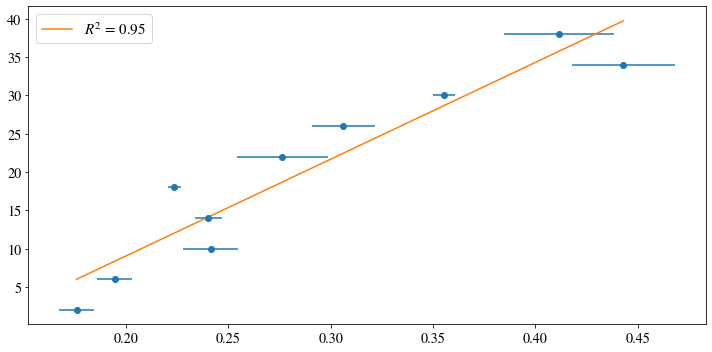

In [37]:
fr_split = 3140
fit_li_ratio = Plot_ratio2(fr_split)

In [38]:
Pred_Er = pd.DataFrame({'n':list(Data_test.keys()),'Energy ratio':E_ratio(fr_split)})
Pred_Er['Prediction'] = np.rint(fit_li_ratio(Pred_Er['Energy ratio'])).astype(int)
Pred_Er['Error'] = np.rint(np.abs((1-Pred_Er['Prediction']/Pred_Er['n']))*100).astype(int)
Mean_error_ratio = str(int(np.rint(np.mean(Pred_Er['Error']))))+'%'
# style
Pred_Er = Pred_Er.drop(columns=['Energy ratio'])
Pred_Er['Error'] = Pred_Er['Error'].astype(str) + '%'
st = Pred_Er.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
st.set_properties(**{'text-align': 'center'}).hide_index()

In [39]:
print(Mean_error_ratio)

24%


## Flatness test

In [40]:
Flatness_test = []
for y in Data_test.values():
  Flatness_test.append(flatness(y))
Flatness_test = np.array(Flatness_test)

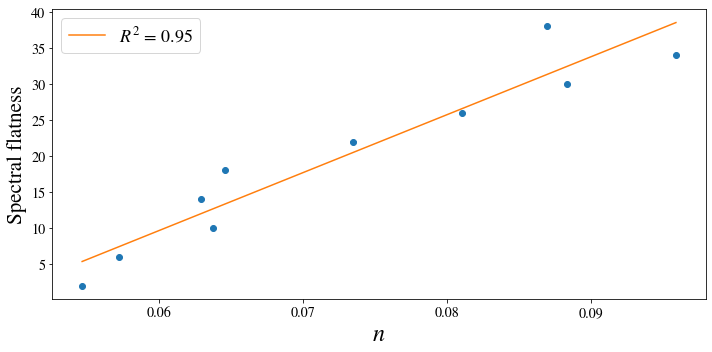

In [41]:
Flatness = DATA.applymap(flatness)
F = Flatness.mean().values

plt.errorbar( F,N, yerr = Flatness.std().values,fmt = 'o',capsize=3)

pa_fla = lambda x, a,b: a*x+b
pa_fla_params, fit_pa_fla = Fit(pa_fla,F,N)
plt.legend(fontsize=18)
#plt.hlines(E[0],-4,301,'gold',linestyles='dashed', lw=2.5)
plt.ylabel('Spectral flatness', size=21)
plt.xlabel('$n$', size=24);

In [42]:
Pred_fla = pd.DataFrame({'n':list(Data_test.keys())})
Pred_fla['Prediction'] = np.rint(fit_pa_fla(Flatness_test)).astype(int)
Pred_fla['Error'] = np.rint(np.abs((1-Pred_fla['Prediction']/Pred_fla['n']))*100).astype(int)

Mean_error_fla = str(int(np.rint(np.mean(Pred_fla['Error']))))+'%'
# style
Pred_fla['Error'] = Pred_fla['Error'].astype(str) + '%'
st = Pred_fla.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
st.set_properties(**{'text-align': 'center'}).hide_index()

In [43]:
print(Mean_error_fla)

11%


In [44]:
Pred_model_en

array([0, 0, 0, 0, 0, 1, 1, 1, 1])

In [45]:
Pred_model_li

array([0, 0, 0, 0, 1, 1, 1, 1, 1])

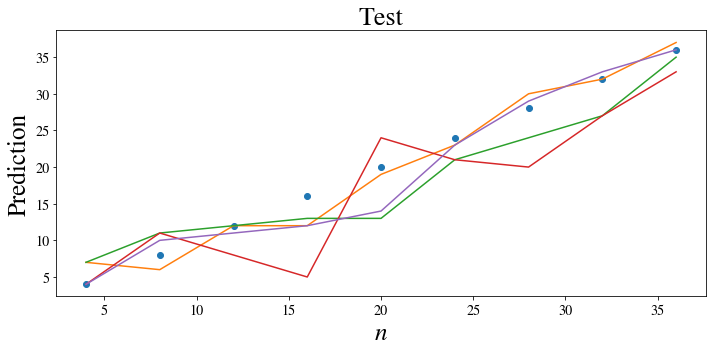

In [46]:
N_test = Pred_en['n'].values
Flatness_pred = Pred_fla['Prediction'].values
Er_pred = Pred_Er['Prediction'].values
Mfcc_pred = np.concatenate([Pred_li['1st Prediction'].values[:4],Pred_li['2nd Prediction'].values[4:]])
En_pred = np.concatenate([Pred_en['1st Prediction'].values[:5],Pred_en['2nd Prediction'].values[5:]])

Preds = [En_pred,Er_pred,Mfcc_pred,Flatness_pred]
Labels = ['0th','1st','2nd','3rd']
plt.plot(N_test,N_test,'o',label='Real')
for pr,la in zip(Preds,Labels):
  plt.plot(N_test,pr,label=la)
  plt.title('Test', size=26)
  plt.ylabel('Prediction',size=25)
  plt.xlabel('$n$',size=25)
plt.legend(fontsize=14)

In [47]:
Mean_error = pd.DataFrame({'Models':['0th','1st','2nd','3rd'], 'Mean error':[Mean_error_en,Mean_error_ratio,Mean_error_li,Mean_error_fla]})
st = Mean_error.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
st.set_properties(**{'text-align': 'center'}).hide_index()